In [1]:
"""
This script is used to compute Alpha9 from dataset 9, I consider following topics here:
- 4 candidate models to compare
- Whether neutralizing proposed Alpha to provided risk factors is helpful to the portfolio 
"""

%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import sys
sys.path.append('..') # Adds higher directory to python modules path.

print(f"Current working dir is {os.getcwd()}\n")

# Load utils functions
from math_trend import *
from utils import *

plt.rcParams['figure.figsize'] = [15, 7]
plt.style.use("ggplot")

# Settings
ROOT = '/home/jma/Python3.7/Cubist_2021_11' ### please make sure you change root before the run
PROCESSED_DATA_DIR = os.path.join(ROOT, 'processed_data')

in_sample_start_date = '2011-01-01'
in_sample_end_date = '2016-01-01'

dtcol = 'pos_date'
seccol = 'security_id'

Current working dir is /home/jma/Python3.7/Cubist_2021_11/alphas



In [2]:
load_file_path = os.path.join(PROCESSED_DATA_DIR, 'known_df_on_data_date.csv.gz')
print(f"Loading processed aggregated dataframe from {load_file_path}")
big_df = pd.read_csv(load_file_path,
                    parse_dates=['data_date', 'pos_date', 'ret_date'], dtype={seccol: str},
                    usecols = ['data_date', 'pos_date', 'ret_date', seccol, 'd9', 'fwdret_f1', 'trd_price', 
                               'volume', 'in_trading_universe', 'sector', 'clip_trisk'])

assert not big_df.duplicated(subset=[dtcol, seccol]).any(), "There are duplicated key pairs!"
big_df.sort_values(by=[dtcol, seccol], inplace=True)

Loading processed aggregated dataframe from /home/jma/Python3.7/Cubist_2021_11/processed_data/known_df_on_data_date.csv.gz


In [3]:
# print(big_df.head(), '\n')
print(f"big_df.tail():\n{big_df.tail()}\n")
print(f"big_df.shape:{big_df.shape}\n")
print(f"big_df.describe():\n{big_df.describe()}\n")

big_df.tail():
         data_date security_id       d9   pos_date   ret_date  fwdret_f1  \
5229186 2017-12-27     9789701    5.985 2017-12-28 2017-12-29   0.000000   
5229187 2017-12-27     9827901  100.000 2017-12-28 2017-12-29  -0.013043   
5229188 2017-12-27      985601   19.270 2017-12-28 2017-12-29  -0.013173   
5229189 2017-12-27      995201    7.020 2017-12-28 2017-12-29  -0.008429   
5229190 2017-12-27      996501    0.590 2017-12-28 2017-12-29  -0.004859   

         trd_price   volume in_trading_universe                  sector  \
5229186      36.18   423933                   Y                  Energy   
5229187       2.30   108757                   N             Health Care   
5229188      26.57  1182623                   Y  Consumer Discretionary   
5229189      79.49   269015                   Y        Consumer Staples   
5229190     296.35  1447837                   Y             Industrials   

         clip_trisk  
5229186   18.560457  
5229187   45.927899  
5229188   3

In [4]:
print(f"Percentage of valid d9 score within each sector:\n\n{round(big_df.loc[big_df['d9'].notnull(), 'sector'].value_counts() / len(big_df.dropna(subset=['d9'])) * 100, 2)}")

Percentage of valid d9 score within each sector:

Financials                18.03
Information Technology    16.51
Health Care               14.83
Consumer Discretionary    14.59
Industrials               13.81
Energy                     7.05
Materials                  5.85
Consumer Staples           4.09
Utilities                  2.85
Communication Services     1.31
Real Estate                1.09
Name: sector, dtype: float64


In [5]:
ds_score = 'd9'

print("Taking out all d9 related columns from the DataFrame")
df = big_df.loc[:, ['pos_date', 'security_id', ds_score, 'clip_trisk', 'fwdret_f1', 'sector']].dropna(subset=[ds_score])

Taking out all d9 related columns from the DataFrame


<AxesSubplot:title={'center':'Daily #Stocks with valid d9 score'}, xlabel='pos_date'>

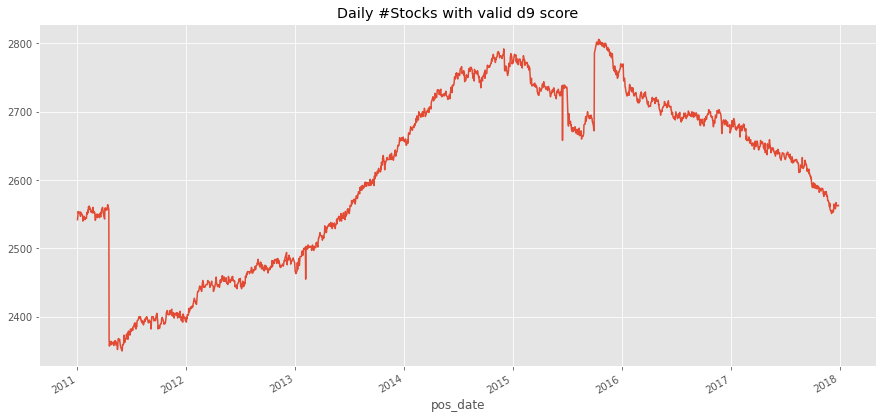

In [6]:
df.loc[df['pos_date'] >= in_sample_start_date].groupby('pos_date').size().plot(title=f'Daily #Stocks with valid {ds_score} score')

Checking on time series value of one random ticker


<AxesSubplot:xlabel='pos_date'>

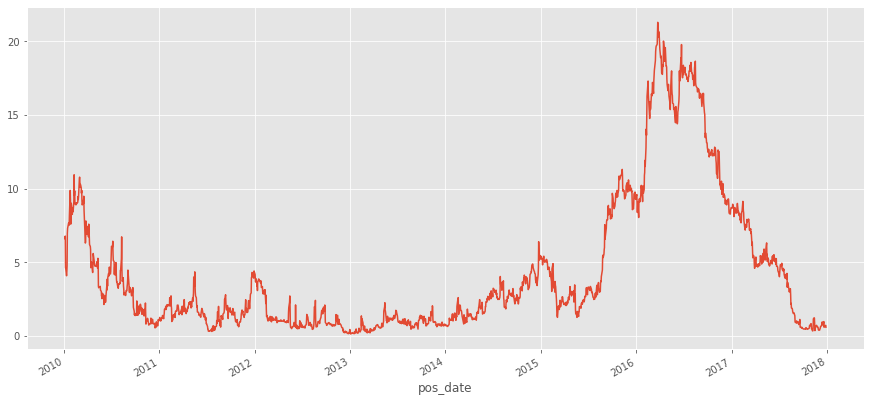

In [7]:
print("Checking on time series value of one random ticker")
df.loc[df[seccol] == '996501'].set_index('pos_date')[ds_score].plot()

In [8]:
clipcol = f"clip_{ds_score}"
print("-	Values outside [0, 100] are clipped to the interval edges")
print(f"-	Using clipped score {clipcol}")
df[clipcol] = df[ds_score].clip(0, 100)

-	Values outside [0, 100] are clipped to the interval edges
-	Using clipped score clip_d9


In [9]:
print(f"Percentage of stocks missing values:\n{round(df.isnull().sum() / df.shape[0] * 100, 2)}\n")
print(f"df.shape:{df.shape}")

Percentage of stocks missing values:
pos_date       0.00
security_id    0.00
d9             0.00
clip_trisk     4.27
fwdret_f1      0.00
sector         0.00
clip_d9        0.00
dtype: float64

df.shape:(5220173, 7)


In [10]:
print("Computing ztrend scores using lookback window = 63, 126 and 252...\n")
df['z252'] = ztrend(df, clipcol, 252, 22, 'pos_date', seccol)
df['z126'] = ztrend(df, clipcol, 126, 22, 'pos_date', seccol)
df['z63'] = ztrend(df, clipcol, 63, 22, 'pos_date', seccol)

Computing ztrend scores using lookback window = 63, 126 and 252...



In [11]:
print("Replace invalid values with NaNs...\n")
df['z252'] = df['z252'].replace([0, -np.inf, np.inf], np.nan)
df['z126'] = df['z126'].replace([0, -np.inf, np.inf], np.nan)
df['z63'] = df['z63'].replace([0, -np.inf, np.inf], np.nan)

Replace invalid values with NaNs...



In [12]:
print("Taking out daily tradable universe...\n")
rsch_universe = big_df.loc[big_df['in_trading_universe'] == 'Y', ['data_date', 'pos_date', seccol]].copy()

Taking out daily tradable universe...



<AxesSubplot:title={'center':'Daily #Stocks within tradable universe'}, xlabel='pos_date'>

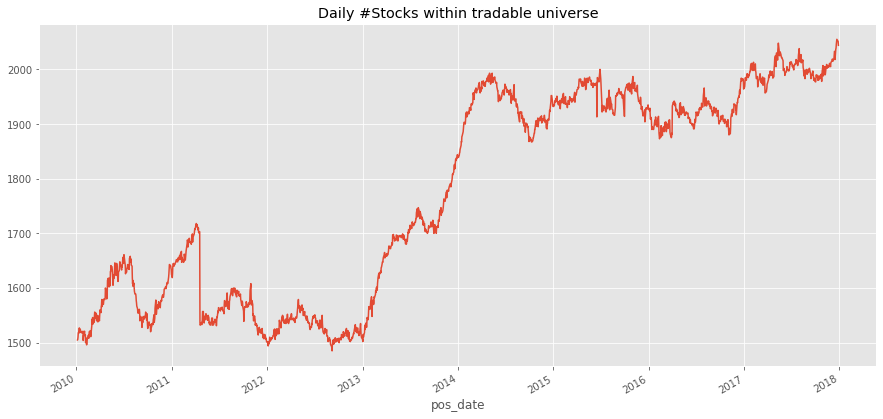

In [13]:
rsch_universe.groupby('pos_date').size().plot(title='Daily #Stocks within tradable universe')

In [14]:
print("Merge alpha_df with tradeable universe\n")
df = df.merge(rsch_universe)

Merge alpha_df with tradeable universe



In [15]:
for zcol in ['z63', 'z126', 'z252']:
    print(f"Cross sectionally normalizing score {zcol}\n")
    df[f'{zcol}_score'] = wins_qnt_score(df, zcol, 'pos_date', qmin=0.05, qmax=0.95)
    df[f'{zcol}_score'] = std_qnt_score(df, f'{zcol}_score', ['sector', 'pos_date'], demean=True)
    df[f'{zcol}_score'] = df[f'{zcol}_score'].clip(-3, 3)
    df[f'{zcol}_score'] = -df[f'{zcol}_score']

Cross sectionally normalizing score z63



/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


Cross sectionally normalizing score z126



/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


Cross sectionally normalizing score z252



/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


## There are 3 candidate Alpha models coming from different lookback window for ztrend calculation, and then taking the simple average among them as the 4th one

In [16]:
print("Checking the descriptive stats and correlation of three candidate alphas\n")
print(df[['z63_score', 'z126_score', 'z252_score']].describe(), "\n")
print(df[['z63_score', 'z126_score', 'z252_score']].corr().round(2))

Checking the descriptive stats and correlation of three candidate alphas

          z63_score    z126_score    z252_score
count  3.511342e+06  3.519712e+06  3.523249e+06
mean   2.405676e-09  6.510618e-08  2.474361e-07
std    9.971147e-01  9.971214e-01  9.971238e-01
min   -3.000000e+00 -3.000000e+00 -3.000000e+00
25%   -7.712170e-01 -7.591874e-01 -7.274734e-01
50%    1.073591e-01  1.274066e-01  1.585964e-01
75%    7.946954e-01  7.905311e-01  7.788171e-01
max    2.393434e+00  2.359551e+00  2.266031e+00 

            z63_score  z126_score  z252_score
z63_score        1.00        0.87        0.70
z126_score       0.87        1.00        0.88
z252_score       0.70        0.88        1.00


## Since 63, 126 and 252 are popular choice for ztrending, I add the 4th candidate by taking the simple average of the previous three and re-normalize

In [17]:
print("Adding the fourth candidate alpha\n")
print("Taking the simple average of the three candidate alphas\n")
df['combined_score'] = df[['z63_score', 'z126_score', 'z252_score']].mean(axis=1)

print("XS normalization every day\n")
df['combined_score'] = std_qnt_score(df, 'combined_score', 'pos_date', demean=True)

print("Clipping the final score at +/- 3\n")
df['combined_score'] = df['combined_score'].clip(-3, 3)

Adding the fourth candidate alpha

Taking the simple average of the three candidate alphas

XS normalization every day

Clipping the final score at +/- 3



In [18]:
print(f"We have 4 candidate alphas from dataset_9, split the time series into in-sample and out-of-sample")
df_is = df.loc[df[dtcol].between(in_sample_start_date, in_sample_end_date, inclusive=True)].copy()
df_os = df.loc[df[dtcol]> in_sample_start_date].copy()

We have 4 candidate alphas from dataset_9, split the time series into in-sample and out-of-sample


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  


Running analyzer for in-sample z63 alpha:

Running analyzer for in-sample z126 alpha:

Running analyzer for in-sample z252 alpha:

Running analyzer for in-sample simple-average alpha:

z63_score stats:
      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0153  0.0102  252.0  1.4976   1587  0.2627
2012  0.0073  0.0082  250.0  0.8879   1523  0.2707
2013  0.0177  0.0071  252.0  2.4711   1688  0.2664
2014  0.0201  0.0087  252.0  2.3061   1927  0.2793
2015  0.0057  0.0091  252.0  0.6295   1948  0.2696

z126_score stats:
      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0171  0.0112  252.0  1.5209   1587  0.2043
2012  0.0144  0.0085  250.0  1.6953   1523  0.2084
2013  0.0109  0.0074  252.0  1.4758   1688  0.2038
2014  0.0151  0.0096  252.0  1.5805   1927  0.2147
2015  0.0008  0.0097  252.0  0.0839   1948  0.2070

z252_score stats:
      AnnRet  AnnVol   Days   AnnSR  Count   A

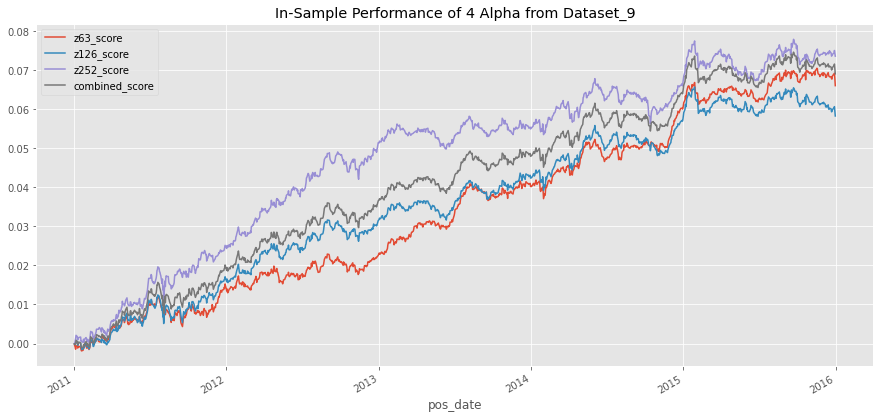

In [19]:
### RUNNING in sampler performance for alpha selection 
print("Running analyzer for in-sample z63 alpha:\n")
dret_is_z63, ystats_is_z63 = \
    quickstats(df_is, 'z63_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

print("Running analyzer for in-sample z126 alpha:\n")
dret_is_z126, ystats_is_z126 = \
    quickstats(df_is, 'z126_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

print("Running analyzer for in-sample z252 alpha:\n")
dret_is_z252, ystats_is_z252 = \
    quickstats(df_is, 'z252_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
    
print("Running analyzer for in-sample simple-average alpha:\n")
dret_is_combined, ystats_is_combined = \
    quickstats(df_is, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.title('In-Sample Performance of 4 Alpha from Dataset_9'); 
plt.legend(['z63_score', 'z126_score', 'z252_score', 'combined_score'], loc='upper left')

print(f"z63_score stats:\n{ystats_is_z63}\n")
print(f"z126_score stats:\n{ystats_is_z126}\n")
print(f"z252_score stats:\n{ystats_is_z252}\n")
print(f"combined_score stats:\n{ystats_is_combined}\n")

## From above stats and plots, the combined_score(brown color, aka 4th candidate) shows consistent performance throughout the years, and has the benefit of balancing different lookback windows, reducing the likelihood of overfitting, thus I choose this construction and going to use for out-of-sample testing

In [20]:
print("Calc Yearly MaxDD and the Length within in sample period\n")

dret_is_combined['year'] = dret_is_combined['pos_date'].dt.year
print(dret_is_combined.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print(f"Max Drawdown of all time:\n")
print(calc_drawdown(dret_is_combined.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length within in sample period

      Max_Drawdown  Length
year                      
2011        -0.008    10.0
2012        -0.006    50.0
2013        -0.005    30.0
2014        -0.007    93.0
2015        -0.008   105.0 

Max Drawdown of all time:

Max_Drawdown     -0.008
Length          105.000
dtype: float64


In [21]:
## annulized tcost in percentage 
0.20 * 252 * 0.0001

0.005040000000000001

<AxesSubplot:title={'center':'Daily Turnover Rate of In-Sample Combined_Alpha'}, xlabel='pos_date'>

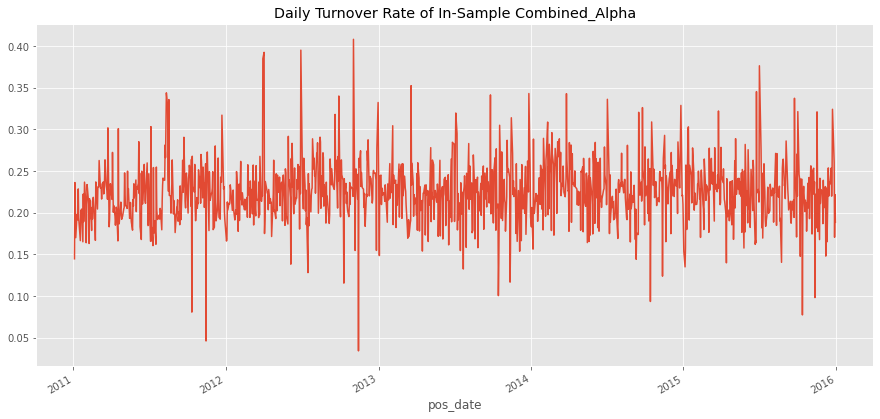

In [22]:
to_is = calc_daily_to(df_is, 'combined_score', 'pos_date', 'security_id')
to_is.plot(title='Daily Turnover Rate of In-Sample Combined_Alpha')

In [23]:
print("Compute % of positive portfolio return days for each In-Sample year:")
dret_is_combined.loc[dret_is_combined['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each In-Sample year:


year
2011    56.35
2012    57.20
2013    52.78
2014    58.33
2015    53.57
Name: attr_fwdretf1, dtype: float64

## If my guess was correct, this dataset was related to the ratio between short_interest and float_shares, we may want to consider neutralizing the generated factor to some well-known risk factors, especially 'Crowding', which is normally comprised of Analyst Recommendation, Analyst Revision, Short Interest and F13. Therefore I want to compute 1) the loading correlations between this Alpha and provided risk factors, 2) Portfolio performance of neutralized version

In [24]:
"""
Considering to neutralize Alpha9 to provided risk factors

"""
### loading risk factors data
with zipfile.ZipFile(os.path.join(ROOT, 'risk_factors.zip')) as zf:
    risk_factors = pd.read_csv(zf.open('risk_factors.csv'), parse_dates=['data_date'], 
                     dtype={'security_id': str, 'rf1': np.float64, 'rf2': np.float64, 'rf3': np.float64, 
                            'rf4': np.float64, 'rf5': np.float64, 'rf6': np.float64})

In [25]:
assert not risk_factors.duplicated(subset=['data_date', seccol]).any(), "There are duplicated values based on the keys"

print("Checking the data types")
print(risk_factors.dtypes)

riskfacs = ['rf1', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6']

Checking the data types
data_date      datetime64[ns]
security_id            object
rf1                   float64
rf2                   float64
rf3                   float64
rf4                   float64
rf5                   float64
rf6                   float64
dtype: object


In [26]:
print(f"Descriptive stats for all 6 risk factors:\n\n{risk_factors[riskfacs].describe().round(2)}")

Descriptive stats for all 6 risk factors:

              rf1         rf2         rf3         rf4         rf5         rf6
count  8800015.00  8800015.00  8800015.00  8800015.00  8800015.00  8800015.00
mean         0.06       -0.29        0.57        0.47       -0.01       -0.50
std          1.17        1.16        1.27        1.20        1.11        1.29
min         -3.07       -3.17       -2.89       -2.82       -2.98       -3.39
25%         -0.72       -0.90       -0.46       -0.40       -0.69       -1.14
50%          0.06       -0.21        0.26        0.28       -0.06       -0.24
75%          0.84        0.37        1.59        1.22        0.60        0.26
max          3.70        2.95        3.03        3.28        2.98        2.79


In [27]:
print("Merging risk factor df with daily tradable universe")
risk_factors = risk_factors.merge(rsch_universe)

Merging risk factor df with daily tradable universe


In [28]:
print("Merging the alphas with risk factor based on pos_date")
rf_df_is = risk_factors.merge(df_is[['pos_date', seccol, 'combined_score', 'clip_trisk', 'fwdret_f1']])

Merging the alphas with risk factor based on pos_date


In [29]:
rf_df_is = rf_df_is.loc[rf_df_is['pos_date'] >= in_sample_start_date]
print(rf_df_is.head())

   data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6   pos_date  \
0 2010-12-31     2297301 -0.060  0.554  0.790 -0.133  0.634  0.028 2011-01-03   
1 2010-12-31     4159901  0.609 -2.354  1.092  1.901  0.826 -2.952 2011-01-03   
2 2010-12-31     4914901  0.696 -0.483 -0.945  1.101  0.062  0.320 2011-01-03   
3 2010-12-31      599401  1.189  0.168 -1.317  0.900 -0.750  0.077 2011-01-03   
4 2010-12-31     5779301  0.139 -0.747 -0.965  0.824 -0.065  0.069 2011-01-03   

   combined_score  clip_trisk  fwdret_f1  
0        0.729064   29.938564  -0.007322  
1        0.596532   49.828648   0.006712  
2        0.376203   29.468231   0.017044  
3        0.922094   35.990888   0.008866  
4       -1.130723   27.387660  -0.012987  


In [30]:
print(rf_df_is[['combined_score'] + riskfacs].corr().round(4))
print(rf_df_is[['combined_score'] + riskfacs].isnull().sum())

print("Dropping NaNs from alpha score column")
rf_df_is.dropna(subset=['combined_score'], inplace=True)

                combined_score     rf1     rf2     rf3     rf4     rf5     rf6
combined_score          1.0000 -0.0134  0.0872 -0.0233 -0.0255 -0.0099 -0.0288
rf1                    -0.0134  1.0000  0.0375  0.0625 -0.0093  0.1258 -0.1504
rf2                     0.0872  0.0375  1.0000 -0.0301 -0.3501  0.0528 -0.1107
rf3                    -0.0233  0.0625 -0.0301  1.0000 -0.1622  0.2697 -0.3905
rf4                    -0.0255 -0.0093 -0.3501 -0.1622  1.0000 -0.3053  0.3489
rf5                    -0.0099  0.1258  0.0528  0.2697 -0.3053  1.0000 -0.1151
rf6                    -0.0288 -0.1504 -0.1107 -0.3905  0.3489 -0.1151  1.0000
combined_score    1425
rf1                  0
rf2                  0
rf3                  0
rf4                  0
rf5                  0
rf6                  0
dtype: int64
Dropping NaNs from alpha score column


In [31]:
print("Neutralizing Alpha to all 6 provided risk factors...\n")
rf_df_is_residual = orthogonalize(rf_df_is, 'combined_score', riskfacs)

Neutralizing Alpha to all 6 provided risk factors...

Processing date 2011-01-03 00:00:00
    Fitted adjusted R^2 is 0.016396197029181714
Processing date 2011-01-04 00:00:00
    Fitted adjusted R^2 is 0.017886773195515127
Processing date 2011-01-05 00:00:00
    Fitted adjusted R^2 is 0.019453381830764394
Processing date 2011-01-06 00:00:00
    Fitted adjusted R^2 is 0.01986444252286601
Processing date 2011-01-07 00:00:00
    Fitted adjusted R^2 is 0.02173549059098745
Processing date 2011-01-10 00:00:00
    Fitted adjusted R^2 is 0.01995526372473022
Processing date 2011-01-11 00:00:00
    Fitted adjusted R^2 is 0.02139928628888399
Processing date 2011-01-12 00:00:00
    Fitted adjusted R^2 is 0.02491728182282371
Processing date 2011-01-13 00:00:00
    Fitted adjusted R^2 is 0.026464691635625703
Processing date 2011-01-14 00:00:00
    Fitted adjusted R^2 is 0.02283277330433864
Processing date 2011-01-18 00:00:00
    Fitted adjusted R^2 is 0.029198668399085248
Processing date 2011-01-19 0

    Fitted adjusted R^2 is 0.011659919228846238
Processing date 2011-05-27 00:00:00
    Fitted adjusted R^2 is 0.01645617754967832
Processing date 2011-05-31 00:00:00
    Fitted adjusted R^2 is 0.014348231716504456
Processing date 2011-06-01 00:00:00
    Fitted adjusted R^2 is 0.011594638516169709
Processing date 2011-06-02 00:00:00
    Fitted adjusted R^2 is 0.008043350409254413
Processing date 2011-06-03 00:00:00
    Fitted adjusted R^2 is 0.007325893198911082
Processing date 2011-06-06 00:00:00
    Fitted adjusted R^2 is 0.008141765650925059
Processing date 2011-06-07 00:00:00
    Fitted adjusted R^2 is 0.007836580240622726
Processing date 2011-06-08 00:00:00
    Fitted adjusted R^2 is 0.008186690583957268
Processing date 2011-06-09 00:00:00
    Fitted adjusted R^2 is 0.00707312833860585
Processing date 2011-06-10 00:00:00
    Fitted adjusted R^2 is 0.008647888278500937
Processing date 2011-06-13 00:00:00
    Fitted adjusted R^2 is 0.008142938946983702
Processing date 2011-06-14 00:

    Fitted adjusted R^2 is 0.0053330130542849075
Processing date 2011-10-17 00:00:00
    Fitted adjusted R^2 is 0.00850335426984794
Processing date 2011-10-18 00:00:00
    Fitted adjusted R^2 is 0.006965738529255194
Processing date 2011-10-19 00:00:00
    Fitted adjusted R^2 is 0.017825846637421927
Processing date 2011-10-20 00:00:00
    Fitted adjusted R^2 is 0.013321596390138857
Processing date 2011-10-21 00:00:00
    Fitted adjusted R^2 is 0.016704443261052027
Processing date 2011-10-24 00:00:00
    Fitted adjusted R^2 is 0.016665703869595427
Processing date 2011-10-25 00:00:00
    Fitted adjusted R^2 is 0.013220858442578143
Processing date 2011-10-26 00:00:00
    Fitted adjusted R^2 is 0.015585963379405321
Processing date 2011-10-27 00:00:00
    Fitted adjusted R^2 is 0.01609143491166476
Processing date 2011-10-28 00:00:00
    Fitted adjusted R^2 is 0.01497050445112269
Processing date 2011-10-31 00:00:00
    Fitted adjusted R^2 is 0.014370491074256253
Processing date 2011-11-01 00:

    Fitted adjusted R^2 is 0.039297076216564863
Processing date 2012-03-13 00:00:00
    Fitted adjusted R^2 is 0.03606552306651811
Processing date 2012-03-14 00:00:00
    Fitted adjusted R^2 is 0.035591357745672236
Processing date 2012-03-15 00:00:00
    Fitted adjusted R^2 is 0.035314051336180485
Processing date 2012-03-16 00:00:00
    Fitted adjusted R^2 is 0.032533365965886185
Processing date 2012-03-19 00:00:00
    Fitted adjusted R^2 is 0.0347899367058222
Processing date 2012-03-20 00:00:00
    Fitted adjusted R^2 is 0.03725660256218288
Processing date 2012-03-21 00:00:00
    Fitted adjusted R^2 is 0.03464219909232713
Processing date 2012-03-22 00:00:00
    Fitted adjusted R^2 is 0.029826497614433012
Processing date 2012-03-23 00:00:00
    Fitted adjusted R^2 is 0.03845843282645245
Processing date 2012-03-26 00:00:00
    Fitted adjusted R^2 is 0.03629354670053442
Processing date 2012-03-27 00:00:00
    Fitted adjusted R^2 is 0.03363549629738327
Processing date 2012-03-28 00:00:00


    Fitted adjusted R^2 is 0.016140847971216177
Processing date 2012-08-01 00:00:00
    Fitted adjusted R^2 is 0.014655884236641215
Processing date 2012-08-02 00:00:00
    Fitted adjusted R^2 is 0.013939200080934966
Processing date 2012-08-03 00:00:00
    Fitted adjusted R^2 is 0.011260350465429614
Processing date 2012-08-06 00:00:00
    Fitted adjusted R^2 is 0.009669908235358626
Processing date 2012-08-07 00:00:00
    Fitted adjusted R^2 is 0.007496257103205672
Processing date 2012-08-08 00:00:00
    Fitted adjusted R^2 is 0.006845021361313486
Processing date 2012-08-09 00:00:00
    Fitted adjusted R^2 is 0.010443931340140766
Processing date 2012-08-10 00:00:00
    Fitted adjusted R^2 is 0.008806648185699872
Processing date 2012-08-13 00:00:00
    Fitted adjusted R^2 is 0.0059779174652104805
Processing date 2012-08-14 00:00:00
    Fitted adjusted R^2 is 0.0061149839611222
Processing date 2012-08-15 00:00:00
    Fitted adjusted R^2 is 0.0056884014521688675
Processing date 2012-08-16 0

    Fitted adjusted R^2 is 0.0032859432199414673
Processing date 2012-12-21 00:00:00
    Fitted adjusted R^2 is 0.0006187155456156557
Processing date 2012-12-24 00:00:00
    Fitted adjusted R^2 is 0.001663310564809506
Processing date 2012-12-26 00:00:00
    Fitted adjusted R^2 is 0.0019591503654977638
Processing date 2012-12-27 00:00:00
    Fitted adjusted R^2 is 0.003073601177485008
Processing date 2012-12-28 00:00:00
    Fitted adjusted R^2 is 0.005902241974800271
Processing date 2012-12-31 00:00:00
    Fitted adjusted R^2 is 0.004886686141811092
Processing date 2013-01-02 00:00:00
    Fitted adjusted R^2 is 0.0032234138842310855
Processing date 2013-01-03 00:00:00
    Fitted adjusted R^2 is 0.006608828521258325
Processing date 2013-01-04 00:00:00
    Fitted adjusted R^2 is 0.004552446195914328
Processing date 2013-01-07 00:00:00
    Fitted adjusted R^2 is 0.005253655824958514
Processing date 2013-01-08 00:00:00
    Fitted adjusted R^2 is 0.005518927374385751
Processing date 2013-01-

    Fitted adjusted R^2 is 0.01637605804104536
Processing date 2013-05-20 00:00:00
    Fitted adjusted R^2 is 0.01598670465841312
Processing date 2013-05-21 00:00:00
    Fitted adjusted R^2 is 0.017483966531780082
Processing date 2013-05-22 00:00:00
    Fitted adjusted R^2 is 0.018169712598352095
Processing date 2013-05-23 00:00:00
    Fitted adjusted R^2 is 0.018452060185361607
Processing date 2013-05-24 00:00:00
    Fitted adjusted R^2 is 0.020997876989979236
Processing date 2013-05-28 00:00:00
    Fitted adjusted R^2 is 0.02649228907562795
Processing date 2013-05-29 00:00:00
    Fitted adjusted R^2 is 0.026759671105314298
Processing date 2013-05-30 00:00:00
    Fitted adjusted R^2 is 0.027471864469020613
Processing date 2013-05-31 00:00:00
    Fitted adjusted R^2 is 0.03089710288591918
Processing date 2013-06-03 00:00:00
    Fitted adjusted R^2 is 0.025987386570747173
Processing date 2013-06-04 00:00:00
    Fitted adjusted R^2 is 0.027979777832807584
Processing date 2013-06-05 00:00

    Fitted adjusted R^2 is 0.007513366872721972
Processing date 2013-10-14 00:00:00
    Fitted adjusted R^2 is 0.008124460590347105
Processing date 2013-10-15 00:00:00
    Fitted adjusted R^2 is 0.007815699057673431
Processing date 2013-10-16 00:00:00
    Fitted adjusted R^2 is 0.007443968880967433
Processing date 2013-10-17 00:00:00
    Fitted adjusted R^2 is 0.005557988376110323
Processing date 2013-10-18 00:00:00
    Fitted adjusted R^2 is 0.005138548881156835
Processing date 2013-10-21 00:00:00
    Fitted adjusted R^2 is 0.00420666426679972
Processing date 2013-10-22 00:00:00
    Fitted adjusted R^2 is 0.005079594814541344
Processing date 2013-10-23 00:00:00
    Fitted adjusted R^2 is 0.002329995492881709
Processing date 2013-10-24 00:00:00
    Fitted adjusted R^2 is 0.00262456556896018
Processing date 2013-10-25 00:00:00
    Fitted adjusted R^2 is 0.00477347878395451
Processing date 2013-10-28 00:00:00
    Fitted adjusted R^2 is 0.006132828597660289
Processing date 2013-10-29 00:0

    Fitted adjusted R^2 is 0.021056536317972663
Processing date 2014-03-07 00:00:00
    Fitted adjusted R^2 is 0.017817603099685497
Processing date 2014-03-10 00:00:00
    Fitted adjusted R^2 is 0.02080344348699492
Processing date 2014-03-11 00:00:00
    Fitted adjusted R^2 is 0.021177366854516877
Processing date 2014-03-12 00:00:00
    Fitted adjusted R^2 is 0.02055727580613942
Processing date 2014-03-13 00:00:00
    Fitted adjusted R^2 is 0.022918074405643085
Processing date 2014-03-14 00:00:00
    Fitted adjusted R^2 is 0.0189381680645041
Processing date 2014-03-17 00:00:00
    Fitted adjusted R^2 is 0.022665484206154107
Processing date 2014-03-18 00:00:00
    Fitted adjusted R^2 is 0.027430692838806614
Processing date 2014-03-19 00:00:00
    Fitted adjusted R^2 is 0.028666101501155006
Processing date 2014-03-20 00:00:00
    Fitted adjusted R^2 is 0.03417284997127468
Processing date 2014-03-21 00:00:00
    Fitted adjusted R^2 is 0.03178165821644563
Processing date 2014-03-24 00:00:0

    Fitted adjusted R^2 is 0.022393273105204003
Processing date 2014-07-29 00:00:00
    Fitted adjusted R^2 is 0.02213996246757266
Processing date 2014-07-30 00:00:00
    Fitted adjusted R^2 is 0.022732863538164283
Processing date 2014-07-31 00:00:00
    Fitted adjusted R^2 is 0.0224259278313913
Processing date 2014-08-01 00:00:00
    Fitted adjusted R^2 is 0.022321968308800844
Processing date 2014-08-04 00:00:00
    Fitted adjusted R^2 is 0.01930573912072331
Processing date 2014-08-05 00:00:00
    Fitted adjusted R^2 is 0.014289901415943329
Processing date 2014-08-06 00:00:00
    Fitted adjusted R^2 is 0.01344183475441807
Processing date 2014-08-07 00:00:00
    Fitted adjusted R^2 is 0.015229522995674927
Processing date 2014-08-08 00:00:00
    Fitted adjusted R^2 is 0.01739059900111528
Processing date 2014-08-11 00:00:00
    Fitted adjusted R^2 is 0.016371404072890616
Processing date 2014-08-12 00:00:00
    Fitted adjusted R^2 is 0.014418388092158785
Processing date 2014-08-13 00:00:0

    Fitted adjusted R^2 is 0.010922967937798345
Processing date 2014-12-26 00:00:00
    Fitted adjusted R^2 is 0.007877756042574124
Processing date 2014-12-29 00:00:00
    Fitted adjusted R^2 is 0.010424046325717584
Processing date 2014-12-30 00:00:00
    Fitted adjusted R^2 is 0.007427390624951791
Processing date 2014-12-31 00:00:00
    Fitted adjusted R^2 is 0.005705683992576094
Processing date 2015-01-02 00:00:00
    Fitted adjusted R^2 is 0.005758597695586287
Processing date 2015-01-05 00:00:00
    Fitted adjusted R^2 is 0.005425093205247644
Processing date 2015-01-06 00:00:00
    Fitted adjusted R^2 is 0.007276814731662307
Processing date 2015-01-07 00:00:00
    Fitted adjusted R^2 is 0.011337909442234562
Processing date 2015-01-08 00:00:00
    Fitted adjusted R^2 is 0.008906815237331611
Processing date 2015-01-09 00:00:00
    Fitted adjusted R^2 is 0.010979467585498948
Processing date 2015-01-12 00:00:00
    Fitted adjusted R^2 is 0.011199129090442628
Processing date 2015-01-13 0

    Fitted adjusted R^2 is 0.006216959891591434
Processing date 2015-05-20 00:00:00
    Fitted adjusted R^2 is 0.005178359782230579
Processing date 2015-05-21 00:00:00
    Fitted adjusted R^2 is 0.00261982104185976
Processing date 2015-05-22 00:00:00
    Fitted adjusted R^2 is 0.0020388178128858403
Processing date 2015-05-26 00:00:00
    Fitted adjusted R^2 is 0.0034829953202988317
Processing date 2015-05-27 00:00:00
    Fitted adjusted R^2 is 0.006120289154047387
Processing date 2015-05-28 00:00:00
    Fitted adjusted R^2 is 0.007287441629494129
Processing date 2015-05-29 00:00:00
    Fitted adjusted R^2 is 0.007750495997527196
Processing date 2015-06-01 00:00:00
    Fitted adjusted R^2 is 0.009156985221528635
Processing date 2015-06-02 00:00:00
    Fitted adjusted R^2 is 0.011673888986342806
Processing date 2015-06-03 00:00:00
    Fitted adjusted R^2 is 0.00957880081646012
Processing date 2015-06-04 00:00:00
    Fitted adjusted R^2 is 0.009650554714473514
Processing date 2015-06-05 0

    Fitted adjusted R^2 is 0.0018236018280858302
Processing date 2015-10-12 00:00:00
    Fitted adjusted R^2 is 0.001811612574853072
Processing date 2015-10-13 00:00:00
    Fitted adjusted R^2 is 0.0014529921901288434
Processing date 2015-10-14 00:00:00
    Fitted adjusted R^2 is 0.002543792374420595
Processing date 2015-10-15 00:00:00
    Fitted adjusted R^2 is 0.0033062724053438686
Processing date 2015-10-16 00:00:00
    Fitted adjusted R^2 is 0.0017291089860513864
Processing date 2015-10-19 00:00:00
    Fitted adjusted R^2 is 0.0018580609956605487
Processing date 2015-10-20 00:00:00
    Fitted adjusted R^2 is 0.0023183551530367996
Processing date 2015-10-21 00:00:00
    Fitted adjusted R^2 is 0.001609955385723394
Processing date 2015-10-22 00:00:00
    Fitted adjusted R^2 is 0.0024408209095170275
Processing date 2015-10-23 00:00:00
    Fitted adjusted R^2 is 0.0015885348995201554
Processing date 2015-10-26 00:00:00
    Fitted adjusted R^2 is 0.0003645565807095519
Processing date 201

In [32]:
(rf_df_is_residual).head()

data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6   pos_date  \
0 2010-12-31     2297301 -0.060  0.554  0.790 -0.133  0.634  0.028 2011-01-03   
1 2010-12-31     4159901  0.609 -2.354  1.092  1.901  0.826 -2.952 2011-01-03   
2 2010-12-31     4914901  0.696 -0.483 -0.945  1.101  0.062  0.320 2011-01-03   
3 2010-12-31      599401  1.189  0.168 -1.317  0.900 -0.750  0.077 2011-01-03   
4 2010-12-31     5779301  0.139 -0.747 -0.965  0.824 -0.065  0.069 2011-01-03   

   combined_score  clip_trisk  fwdret_f1     Resid  
0        0.729064   29.938564  -0.007322  0.754448  
1        0.596532   49.828648   0.006712  0.894272  
2        0.376203   29.468231   0.017044  0.392656  
3        0.922094   35.990888   0.008866  0.802048  
4       -1.130723   27.387660  -0.012987 -1.094048

In [33]:
print("Computing loading correlation between the ones with and w/o neutralization")
rf_df_is_residual[['combined_score', 'Resid']].corr().round(4)

Computing loading correlation between the ones with and w/o neutralization


combined_score   Resid
combined_score          1.0000  0.9912
Resid                   0.9912  1.0000

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0201  0.0115  252.0  1.7550   1585  0.2215
2012  0.0164  0.0089  250.0  1.8397   1523  0.2270
2013  0.0114  0.0075  252.0  1.5288   1686  0.2202
2014  0.0166  0.0097  252.0  1.7081   1926  0.2328
2015  0.0045  0.0101  252.0  0.4476   1947  0.2249 

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0205  0.0106  252.0  1.9248   1585  0.2241
2012  0.0093  0.0078  250.0  1.1935   1523  0.2313
2013  0.0043  0.0071  252.0  0.6102   1686  0.2243
2014  0.0130  0.0088  252.0  1.4843   1926  0.2365
2015  0.0028  0.0082  252.0  0.3446   1947  0.2275 



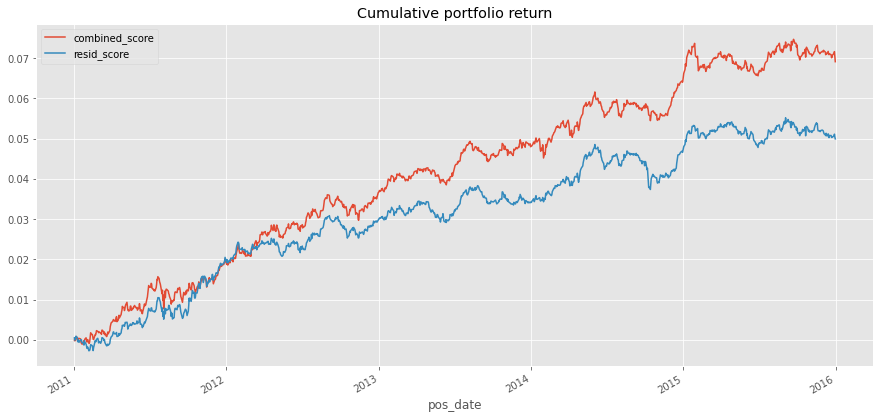

In [34]:
daily_return_raw, stats1 = quickstats(rf_df_is_residual, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
daily_return_resid, stats2 = quickstats(rf_df_is_residual, 'Resid', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.legend(['combined_score', 'resid_score'], loc='upper left')

print(stats1, '\n')
print(stats2, '\n')

## Based on above results, after neutralizing to 6 risk factors, in-sample portfolio performance becomes weaker, and also loading correlation between original_score and orth'ed_score is quite high, ~99%, which implies raw original_score has little exposures to 6 risk factors, so I decide not to pursue neutralization  

rf3 itself has strong return predictability if we flip the sign

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011 -0.0649  0.1150  252.0 -0.5644   1585  0.1234
2012 -0.0849  0.0486  250.0 -1.7463   1523  0.1143
2013 -0.1140  0.0607  252.0 -1.8785   1686  0.1177
2014 -0.0675  0.0530  252.0 -1.2745   1926  0.1534
2015 -0.0094  0.0727  252.0 -0.1291   1947  0.1531


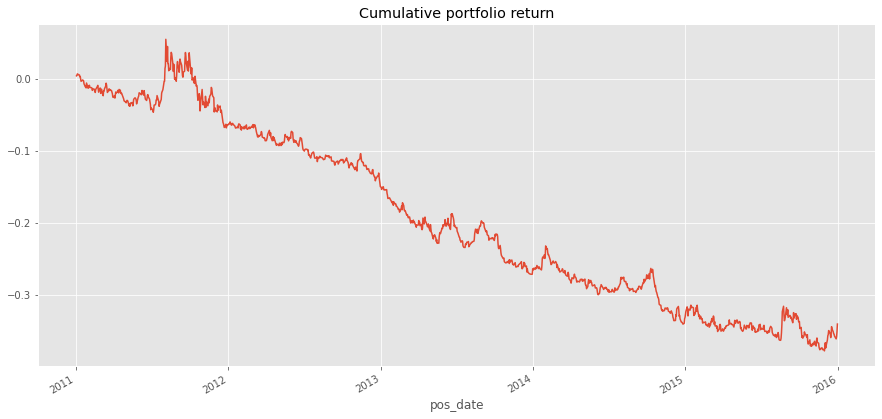

In [35]:
print("rf3 itself has strong return predictability if we flip the sign\n")
_, stats3 = quickstats(rf_df_is_residual, 'rf3', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(stats3)

## Generating portfolio stats of both in-sample and out-of-sample period using original_score, i.e., the 4th candidate alpha model

Running analyzer for all time simple-average alpha, leaving aside 2010 as this year is used to compute realized volatility:

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0201  0.0115  252.0  1.7550   1587  0.2215
2012  0.0164  0.0089  250.0  1.8397   1523  0.2270
2013  0.0114  0.0075  252.0  1.5288   1688  0.2202
2014  0.0166  0.0097  252.0  1.7081   1927  0.2328
2015  0.0045  0.0101  252.0  0.4476   1948  0.2249
2016  0.0066  0.0089  252.0  0.7332   1914  0.2156
2017  0.0195  0.0090  250.0  2.1612   1996  0.2131


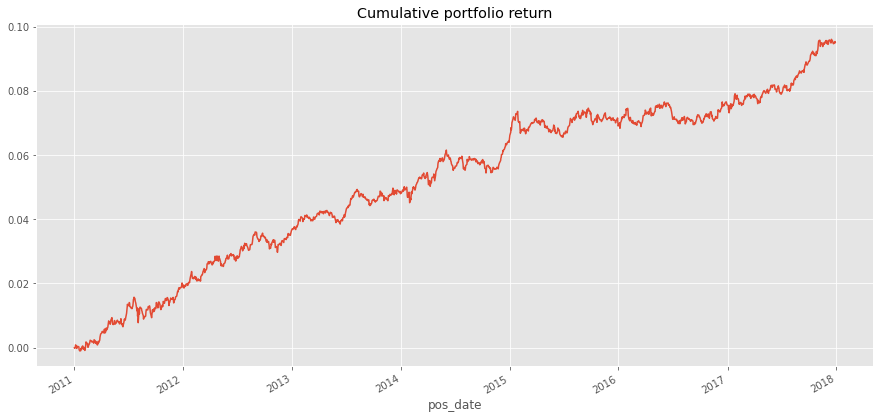

In [36]:
print("Running analyzer for all time simple-average alpha, leaving aside 2010 as this year is used to compute realized volatility:\n")
df = df.loc[df['pos_date'] >= '2011-01-01']
dret_all_combined, ystats_all_combined = \
    quickstats(df, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(ystats_all_combined)

<AxesSubplot:title={'center':'Daily Turnover Rate of All-Time Combined_Alpha'}, xlabel='pos_date'>

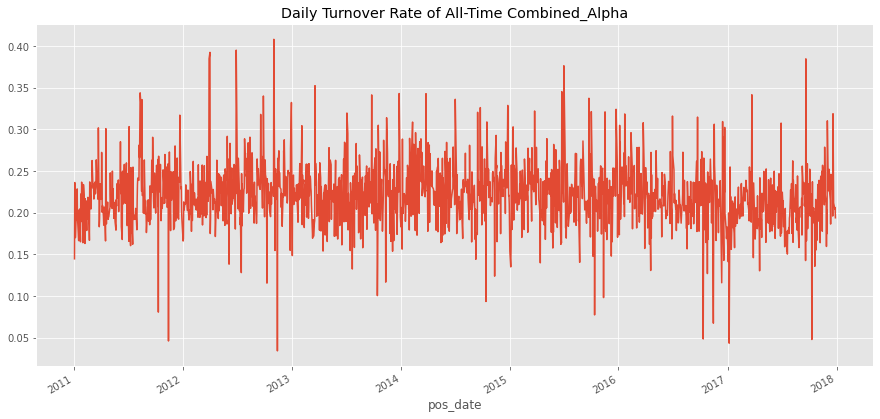

In [37]:
to = calc_daily_to(df, 'combined_score', 'pos_date', 'security_id')
to.plot(title='Daily Turnover Rate of All-Time Combined_Alpha')

In [38]:
print("Calc Yearly MaxDD and the Length\n\n")

dret_all_combined['year'] = dret_all_combined['pos_date'].dt.year
print(dret_all_combined.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(dret_all_combined.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length


      Max_Drawdown  Length
year                      
2011        -0.008    10.0
2012        -0.006    50.0
2013        -0.005    30.0
2014        -0.007    93.0
2015        -0.008   105.0
2016        -0.007    67.0
2017        -0.004    16.0 

Max Drawdown of all times:
 Max_Drawdown     -0.008
Length          105.000
dtype: float64


In [39]:
print("Compute % of positive portfolio return days for each year:")
dret_all_combined.groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    56.35
2012    57.20
2013    52.78
2014    58.33
2015    53.57
2016    50.79
2017    55.60
Name: attr_fwdretf1, dtype: float64

## Generating portfolio stats of both in-sample and out-of-sample period using orth'ed score, i.e., the normalized residual from regressing original_score to all 6 risk factors

In [40]:
# df_risk = df.merge(risk_factors)
# print(df.head())
# print(risk_factors.head())

df_risk = risk_factors.merge(df[['pos_date', seccol, 'combined_score', 'clip_trisk', 'fwdret_f1']])

In [41]:
print("Neutralizing Alpha to all 6 provided risk factors...\n")
df_risk.dropna(subset=['combined_score'], inplace=True)
df_risk_residual = orthogonalize(df_risk, 'combined_score', riskfacs)

Neutralizing Alpha to all 6 provided risk factors...

Processing date 2011-01-03 00:00:00
    Fitted adjusted R^2 is 0.016396197029181714
Processing date 2011-01-04 00:00:00
    Fitted adjusted R^2 is 0.017886773195515127
Processing date 2011-01-05 00:00:00
    Fitted adjusted R^2 is 0.019453381830764394
Processing date 2011-01-06 00:00:00
    Fitted adjusted R^2 is 0.01986444252286601
Processing date 2011-01-07 00:00:00
    Fitted adjusted R^2 is 0.02173549059098745
Processing date 2011-01-10 00:00:00
    Fitted adjusted R^2 is 0.01995526372473022
Processing date 2011-01-11 00:00:00
    Fitted adjusted R^2 is 0.02139928628888399
Processing date 2011-01-12 00:00:00
    Fitted adjusted R^2 is 0.02491728182282371
Processing date 2011-01-13 00:00:00
    Fitted adjusted R^2 is 0.026464691635625703
Processing date 2011-01-14 00:00:00
    Fitted adjusted R^2 is 0.02283277330433864
Processing date 2011-01-18 00:00:00
    Fitted adjusted R^2 is 0.029198668399085248
Processing date 2011-01-19 0

    Fitted adjusted R^2 is 0.01645617754967832
Processing date 2011-05-31 00:00:00
    Fitted adjusted R^2 is 0.014348231716504456
Processing date 2011-06-01 00:00:00
    Fitted adjusted R^2 is 0.011594638516169709
Processing date 2011-06-02 00:00:00
    Fitted adjusted R^2 is 0.008043350409254413
Processing date 2011-06-03 00:00:00
    Fitted adjusted R^2 is 0.007325893198911082
Processing date 2011-06-06 00:00:00
    Fitted adjusted R^2 is 0.008141765650925059
Processing date 2011-06-07 00:00:00
    Fitted adjusted R^2 is 0.007836580240622726
Processing date 2011-06-08 00:00:00
    Fitted adjusted R^2 is 0.008186690583957268
Processing date 2011-06-09 00:00:00
    Fitted adjusted R^2 is 0.00707312833860585
Processing date 2011-06-10 00:00:00
    Fitted adjusted R^2 is 0.008647888278500937
Processing date 2011-06-13 00:00:00
    Fitted adjusted R^2 is 0.008142938946983702
Processing date 2011-06-14 00:00:00
    Fitted adjusted R^2 is 0.005331052894888777
Processing date 2011-06-15 00:

    Fitted adjusted R^2 is 0.016704443261052027
Processing date 2011-10-24 00:00:00
    Fitted adjusted R^2 is 0.016665703869595427
Processing date 2011-10-25 00:00:00
    Fitted adjusted R^2 is 0.013220858442578143
Processing date 2011-10-26 00:00:00
    Fitted adjusted R^2 is 0.015585963379405321
Processing date 2011-10-27 00:00:00
    Fitted adjusted R^2 is 0.01609143491166476
Processing date 2011-10-28 00:00:00
    Fitted adjusted R^2 is 0.01497050445112269
Processing date 2011-10-31 00:00:00
    Fitted adjusted R^2 is 0.014370491074256253
Processing date 2011-11-01 00:00:00
    Fitted adjusted R^2 is 0.02082927626409614
Processing date 2011-11-02 00:00:00
    Fitted adjusted R^2 is 0.016988111851299115
Processing date 2011-11-03 00:00:00
    Fitted adjusted R^2 is 0.015822530659948097
Processing date 2011-11-04 00:00:00
    Fitted adjusted R^2 is 0.006480320295262021
Processing date 2011-11-07 00:00:00
    Fitted adjusted R^2 is 0.012808813128178165
Processing date 2011-11-08 00:0

    Fitted adjusted R^2 is 0.03725660256218288
Processing date 2012-03-21 00:00:00
    Fitted adjusted R^2 is 0.03464219909232713
Processing date 2012-03-22 00:00:00
    Fitted adjusted R^2 is 0.029826497614433012
Processing date 2012-03-23 00:00:00
    Fitted adjusted R^2 is 0.03845843282645245
Processing date 2012-03-26 00:00:00
    Fitted adjusted R^2 is 0.03629354670053442
Processing date 2012-03-27 00:00:00
    Fitted adjusted R^2 is 0.03363549629738327
Processing date 2012-03-28 00:00:00
    Fitted adjusted R^2 is 0.03296890073014258
Processing date 2012-03-29 00:00:00
    Fitted adjusted R^2 is 0.027248906626800684
Processing date 2012-03-30 00:00:00
    Fitted adjusted R^2 is 0.02821462718652512
Processing date 2012-04-02 00:00:00
    Fitted adjusted R^2 is 0.025272020686399332
Processing date 2012-04-03 00:00:00
    Fitted adjusted R^2 is 0.026812986621339463
Processing date 2012-04-04 00:00:00
    Fitted adjusted R^2 is 0.031034728473154582
Processing date 2012-04-05 00:00:00

    Fitted adjusted R^2 is 0.0059779174652104805
Processing date 2012-08-14 00:00:00
    Fitted adjusted R^2 is 0.0061149839611222
Processing date 2012-08-15 00:00:00
    Fitted adjusted R^2 is 0.0056884014521688675
Processing date 2012-08-16 00:00:00
    Fitted adjusted R^2 is 0.00885315882117299
Processing date 2012-08-17 00:00:00
    Fitted adjusted R^2 is 0.006336505984599672
Processing date 2012-08-20 00:00:00
    Fitted adjusted R^2 is 0.008736241768414255
Processing date 2012-08-21 00:00:00
    Fitted adjusted R^2 is 0.014338162615640693
Processing date 2012-08-22 00:00:00
    Fitted adjusted R^2 is 0.01598254262732146
Processing date 2012-08-23 00:00:00
    Fitted adjusted R^2 is 0.01372940186804239
Processing date 2012-08-24 00:00:00
    Fitted adjusted R^2 is 0.013637611003350258
Processing date 2012-08-27 00:00:00
    Fitted adjusted R^2 is 0.01243155345793745
Processing date 2012-08-28 00:00:00
    Fitted adjusted R^2 is 0.01092961712612539
Processing date 2012-08-29 00:00:

    Fitted adjusted R^2 is 0.004552446195914328
Processing date 2013-01-07 00:00:00
    Fitted adjusted R^2 is 0.005253655824958514
Processing date 2013-01-08 00:00:00
    Fitted adjusted R^2 is 0.005518927374385751
Processing date 2013-01-09 00:00:00
    Fitted adjusted R^2 is 0.007474036573117737
Processing date 2013-01-10 00:00:00
    Fitted adjusted R^2 is 0.004777524824894797
Processing date 2013-01-11 00:00:00
    Fitted adjusted R^2 is 0.0030583133551459474
Processing date 2013-01-14 00:00:00
    Fitted adjusted R^2 is 0.0025049535634391606
Processing date 2013-01-15 00:00:00
    Fitted adjusted R^2 is 0.006912147479180675
Processing date 2013-01-16 00:00:00
    Fitted adjusted R^2 is 0.005271643226016365
Processing date 2013-01-17 00:00:00
    Fitted adjusted R^2 is 0.00730685379958651
Processing date 2013-01-18 00:00:00
    Fitted adjusted R^2 is 0.009226004211876249
Processing date 2013-01-22 00:00:00
    Fitted adjusted R^2 is 0.008255410420324183
Processing date 2013-01-23 

    Fitted adjusted R^2 is 0.025987386570747173
Processing date 2013-06-04 00:00:00
    Fitted adjusted R^2 is 0.027979777832807584
Processing date 2013-06-05 00:00:00
    Fitted adjusted R^2 is 0.03009530489786194
Processing date 2013-06-06 00:00:00
    Fitted adjusted R^2 is 0.03141819200600615
Processing date 2013-06-07 00:00:00
    Fitted adjusted R^2 is 0.029079013306071322
Processing date 2013-06-10 00:00:00
    Fitted adjusted R^2 is 0.03216872231102974
Processing date 2013-06-11 00:00:00
    Fitted adjusted R^2 is 0.03708620555564557
Processing date 2013-06-12 00:00:00
    Fitted adjusted R^2 is 0.03498920657063487
Processing date 2013-06-13 00:00:00
    Fitted adjusted R^2 is 0.036698178307009166
Processing date 2013-06-14 00:00:00
    Fitted adjusted R^2 is 0.03242893678607206
Processing date 2013-06-17 00:00:00
    Fitted adjusted R^2 is 0.030851399858752404
Processing date 2013-06-18 00:00:00
    Fitted adjusted R^2 is 0.029300159239191825
Processing date 2013-06-19 00:00:0

    Fitted adjusted R^2 is 0.00420666426679972
Processing date 2013-10-22 00:00:00
    Fitted adjusted R^2 is 0.005079594814541344
Processing date 2013-10-23 00:00:00
    Fitted adjusted R^2 is 0.002329995492881709
Processing date 2013-10-24 00:00:00
    Fitted adjusted R^2 is 0.00262456556896018
Processing date 2013-10-25 00:00:00
    Fitted adjusted R^2 is 0.00477347878395451
Processing date 2013-10-28 00:00:00
    Fitted adjusted R^2 is 0.006132828597660289
Processing date 2013-10-29 00:00:00
    Fitted adjusted R^2 is 0.006994816180398655
Processing date 2013-10-30 00:00:00
    Fitted adjusted R^2 is 0.004969129036537345
Processing date 2013-10-31 00:00:00
    Fitted adjusted R^2 is 0.007749388862471451
Processing date 2013-11-01 00:00:00
    Fitted adjusted R^2 is 0.007927192305281383
Processing date 2013-11-04 00:00:00
    Fitted adjusted R^2 is 0.006946803041974925
Processing date 2013-11-05 00:00:00
    Fitted adjusted R^2 is 0.01357769050462998
Processing date 2013-11-06 00:00

    Fitted adjusted R^2 is 0.03417284997127468
Processing date 2014-03-21 00:00:00
    Fitted adjusted R^2 is 0.03178165821644563
Processing date 2014-03-24 00:00:00
    Fitted adjusted R^2 is 0.029652506154512537
Processing date 2014-03-25 00:00:00
    Fitted adjusted R^2 is 0.026858724666283917
Processing date 2014-03-26 00:00:00
    Fitted adjusted R^2 is 0.027939880112191062
Processing date 2014-03-27 00:00:00
    Fitted adjusted R^2 is 0.02588479852656589
Processing date 2014-03-28 00:00:00
    Fitted adjusted R^2 is 0.030309186658476817
Processing date 2014-03-31 00:00:00
    Fitted adjusted R^2 is 0.030012033107193803
Processing date 2014-04-01 00:00:00
    Fitted adjusted R^2 is 0.0322805405075659
Processing date 2014-04-02 00:00:00
    Fitted adjusted R^2 is 0.03032512226438422
Processing date 2014-04-03 00:00:00
    Fitted adjusted R^2 is 0.031130268243626302
Processing date 2014-04-04 00:00:00
    Fitted adjusted R^2 is 0.028019691428223692
Processing date 2014-04-07 00:00:0

    Fitted adjusted R^2 is 0.015727971897036452
Processing date 2014-08-15 00:00:00
    Fitted adjusted R^2 is 0.010763670807050985
Processing date 2014-08-18 00:00:00
    Fitted adjusted R^2 is 0.00909074319241332
Processing date 2014-08-19 00:00:00
    Fitted adjusted R^2 is 0.009084324516071551
Processing date 2014-08-20 00:00:00
    Fitted adjusted R^2 is 0.007512577184757729
Processing date 2014-08-21 00:00:00
    Fitted adjusted R^2 is 0.009786798773231298
Processing date 2014-08-22 00:00:00
    Fitted adjusted R^2 is 0.009017834780939982
Processing date 2014-08-25 00:00:00
    Fitted adjusted R^2 is 0.009480101143373831
Processing date 2014-08-26 00:00:00
    Fitted adjusted R^2 is 0.008309837037723034
Processing date 2014-08-27 00:00:00
    Fitted adjusted R^2 is 0.009128361025337095
Processing date 2014-08-28 00:00:00
    Fitted adjusted R^2 is 0.011710000850765345
Processing date 2014-08-29 00:00:00
    Fitted adjusted R^2 is 0.010930705118606943
Processing date 2014-09-02 00

    Fitted adjusted R^2 is 0.010979467585498948
Processing date 2015-01-12 00:00:00
    Fitted adjusted R^2 is 0.011199129090442628
Processing date 2015-01-13 00:00:00
    Fitted adjusted R^2 is 0.014916614358077118
Processing date 2015-01-14 00:00:00
    Fitted adjusted R^2 is 0.01563265141489467
Processing date 2015-01-15 00:00:00
    Fitted adjusted R^2 is 0.015986068545967846
Processing date 2015-01-16 00:00:00
    Fitted adjusted R^2 is 0.021437634020926022
Processing date 2015-01-20 00:00:00
    Fitted adjusted R^2 is 0.02101943076844437
Processing date 2015-01-21 00:00:00
    Fitted adjusted R^2 is 0.01925135872124184
Processing date 2015-01-22 00:00:00
    Fitted adjusted R^2 is 0.017944007676998552
Processing date 2015-01-23 00:00:00
    Fitted adjusted R^2 is 0.015330924621037134
Processing date 2015-01-26 00:00:00
    Fitted adjusted R^2 is 0.02148920710663016
Processing date 2015-01-27 00:00:00
    Fitted adjusted R^2 is 0.022252674414098617
Processing date 2015-01-28 00:00

    Fitted adjusted R^2 is 0.00957880081646012
Processing date 2015-06-04 00:00:00
    Fitted adjusted R^2 is 0.009650554714473514
Processing date 2015-06-05 00:00:00
    Fitted adjusted R^2 is 0.00956666920871485
Processing date 2015-06-08 00:00:00
    Fitted adjusted R^2 is 0.009318323143706841
Processing date 2015-06-09 00:00:00
    Fitted adjusted R^2 is 0.009574754658639106
Processing date 2015-06-10 00:00:00
    Fitted adjusted R^2 is 0.010091395900634015
Processing date 2015-06-11 00:00:00
    Fitted adjusted R^2 is 0.010544192080594539
Processing date 2015-06-12 00:00:00
    Fitted adjusted R^2 is 0.012114748359996597
Processing date 2015-06-15 00:00:00
    Fitted adjusted R^2 is 0.009545625696575688
Processing date 2015-06-16 00:00:00
    Fitted adjusted R^2 is 0.01155441938494206
Processing date 2015-06-17 00:00:00
    Fitted adjusted R^2 is 0.011917343514629697
Processing date 2015-06-18 00:00:00
    Fitted adjusted R^2 is 0.011111792316674252
Processing date 2015-06-19 00:0

    Fitted adjusted R^2 is 0.0003645565807095519
Processing date 2015-10-27 00:00:00
    Fitted adjusted R^2 is 0.0016870399372076461
Processing date 2015-10-28 00:00:00
    Fitted adjusted R^2 is 0.0027645426861334643
Processing date 2015-10-29 00:00:00
    Fitted adjusted R^2 is 0.004131785143307365
Processing date 2015-10-30 00:00:00
    Fitted adjusted R^2 is 0.0028608689941691523
Processing date 2015-11-02 00:00:00
    Fitted adjusted R^2 is 0.0017742118262820128
Processing date 2015-11-03 00:00:00
    Fitted adjusted R^2 is 0.0018842203630485832
Processing date 2015-11-04 00:00:00
    Fitted adjusted R^2 is 0.002533818651098585
Processing date 2015-11-05 00:00:00
    Fitted adjusted R^2 is 0.0019509830203889855
Processing date 2015-11-06 00:00:00
    Fitted adjusted R^2 is 0.0009670640225744043
Processing date 2015-11-09 00:00:00
    Fitted adjusted R^2 is 0.0021653267622561145
Processing date 2015-11-10 00:00:00
    Fitted adjusted R^2 is 0.002886094931283667
Processing date 201

    Fitted adjusted R^2 is 0.00782561358038758
Processing date 2016-03-21 00:00:00
    Fitted adjusted R^2 is 0.00932181615837635
Processing date 2016-03-22 00:00:00
    Fitted adjusted R^2 is 0.008355869906479296
Processing date 2016-03-23 00:00:00
    Fitted adjusted R^2 is 0.007413245688913772
Processing date 2016-03-24 00:00:00
    Fitted adjusted R^2 is 0.010600330001623748
Processing date 2016-03-28 00:00:00
    Fitted adjusted R^2 is 0.008730515667003003
Processing date 2016-03-29 00:00:00
    Fitted adjusted R^2 is 0.00747502201325323
Processing date 2016-03-30 00:00:00
    Fitted adjusted R^2 is 0.007052911263875639
Processing date 2016-03-31 00:00:00
    Fitted adjusted R^2 is 0.0065751813564567385
Processing date 2016-04-01 00:00:00
    Fitted adjusted R^2 is 0.005494480294037762
Processing date 2016-04-04 00:00:00
    Fitted adjusted R^2 is 0.0032838648843425133
Processing date 2016-04-05 00:00:00
    Fitted adjusted R^2 is 0.008622210338648517
Processing date 2016-04-06 00

    Fitted adjusted R^2 is 0.00921152973217576
Processing date 2016-08-19 00:00:00
    Fitted adjusted R^2 is 0.00804070153450609
Processing date 2016-08-22 00:00:00
    Fitted adjusted R^2 is 0.00985769363818112
Processing date 2016-08-23 00:00:00
    Fitted adjusted R^2 is 0.00896981696475585
Processing date 2016-08-24 00:00:00
    Fitted adjusted R^2 is 0.008921178002591068
Processing date 2016-08-25 00:00:00
    Fitted adjusted R^2 is 0.005863136021553639
Processing date 2016-08-26 00:00:00
    Fitted adjusted R^2 is 0.006193058166175658
Processing date 2016-08-29 00:00:00
    Fitted adjusted R^2 is 0.006551436321344251
Processing date 2016-08-30 00:00:00
    Fitted adjusted R^2 is 0.007250938753813552
Processing date 2016-08-31 00:00:00
    Fitted adjusted R^2 is 0.009859906667727292
Processing date 2016-09-01 00:00:00
    Fitted adjusted R^2 is 0.012119738977863115
Processing date 2016-09-02 00:00:00
    Fitted adjusted R^2 is 0.01802613391219887
Processing date 2016-09-06 00:00:

    Fitted adjusted R^2 is 0.032369612882125254
Processing date 2017-01-12 00:00:00
    Fitted adjusted R^2 is 0.0303043663594339
Processing date 2017-01-13 00:00:00
    Fitted adjusted R^2 is 0.027314334764020565
Processing date 2017-01-17 00:00:00
    Fitted adjusted R^2 is 0.02791616215490844
Processing date 2017-01-18 00:00:00
    Fitted adjusted R^2 is 0.026185945022004553
Processing date 2017-01-19 00:00:00
    Fitted adjusted R^2 is 0.03257912766073723
Processing date 2017-01-20 00:00:00
    Fitted adjusted R^2 is 0.0310977718597526
Processing date 2017-01-23 00:00:00
    Fitted adjusted R^2 is 0.028143024536714578
Processing date 2017-01-24 00:00:00
    Fitted adjusted R^2 is 0.03043971189080985
Processing date 2017-01-25 00:00:00
    Fitted adjusted R^2 is 0.03383647804530121
Processing date 2017-01-26 00:00:00
    Fitted adjusted R^2 is 0.03796307123364895
Processing date 2017-01-27 00:00:00
    Fitted adjusted R^2 is 0.037825569392414216
Processing date 2017-01-30 00:00:00
 

    Fitted adjusted R^2 is 0.01945723463483595
Processing date 2017-06-08 00:00:00
    Fitted adjusted R^2 is 0.018543568512709996
Processing date 2017-06-09 00:00:00
    Fitted adjusted R^2 is 0.021147860868183987
Processing date 2017-06-12 00:00:00
    Fitted adjusted R^2 is 0.024760993370217088
Processing date 2017-06-13 00:00:00
    Fitted adjusted R^2 is 0.029000702873627215
Processing date 2017-06-14 00:00:00
    Fitted adjusted R^2 is 0.028859519931963562
Processing date 2017-06-15 00:00:00
    Fitted adjusted R^2 is 0.026025167179748898
Processing date 2017-06-16 00:00:00
    Fitted adjusted R^2 is 0.021298628289929233
Processing date 2017-06-19 00:00:00
    Fitted adjusted R^2 is 0.021473447180617278
Processing date 2017-06-20 00:00:00
    Fitted adjusted R^2 is 0.021090579681736
Processing date 2017-06-21 00:00:00
    Fitted adjusted R^2 is 0.026578492094066708
Processing date 2017-06-22 00:00:00
    Fitted adjusted R^2 is 0.026193753721080015
Processing date 2017-06-23 00:00

    Fitted adjusted R^2 is 0.025650944848327084
Processing date 2017-10-27 00:00:00
    Fitted adjusted R^2 is 0.025591966390943188
Processing date 2017-10-30 00:00:00
    Fitted adjusted R^2 is 0.027186742129858166
Processing date 2017-10-31 00:00:00
    Fitted adjusted R^2 is 0.02291444032324752
Processing date 2017-11-01 00:00:00
    Fitted adjusted R^2 is 0.021423259584504528
Processing date 2017-11-02 00:00:00
    Fitted adjusted R^2 is 0.01923063615371834
Processing date 2017-11-03 00:00:00
    Fitted adjusted R^2 is 0.019797378871960092
Processing date 2017-11-06 00:00:00
    Fitted adjusted R^2 is 0.020458734380669363
Processing date 2017-11-07 00:00:00
    Fitted adjusted R^2 is 0.024700052713072962
Processing date 2017-11-08 00:00:00
    Fitted adjusted R^2 is 0.025489144917968942
Processing date 2017-11-09 00:00:00
    Fitted adjusted R^2 is 0.0232720748224563
Processing date 2017-11-10 00:00:00
    Fitted adjusted R^2 is 0.020182304617138436
Processing date 2017-11-13 00:00

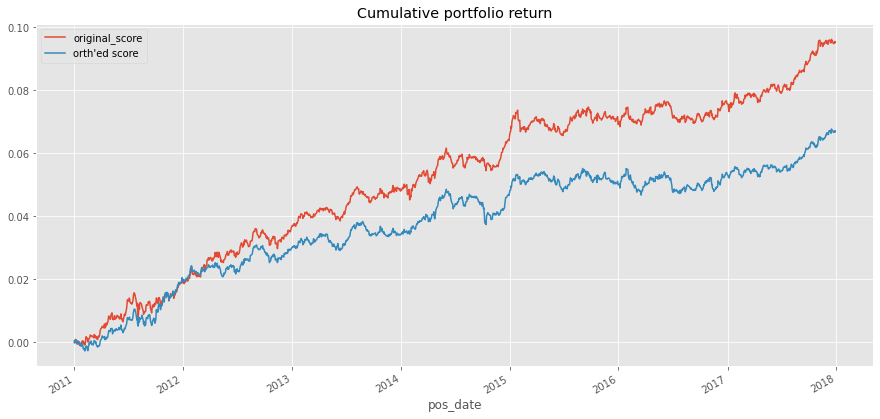

In [42]:
dret_df_risk_original, df_risk_original_stats = \
    quickstats(df_risk_residual, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

dret_df_risk_residual, df_risk_residual_stats = \
    quickstats(df_risk_residual, 'Resid', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.legend(['original_score', "orth'ed score"], loc='upper left')

In [43]:
print(df_risk_residual_stats)

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0205  0.0106  252.0  1.9248   1585  0.2241
2012  0.0093  0.0078  250.0  1.1935   1523  0.2313
2013  0.0043  0.0071  252.0  0.6102   1686  0.2243
2014  0.0130  0.0088  252.0  1.4843   1926  0.2365
2015  0.0028  0.0082  252.0  0.3446   1947  0.2275
2016  0.0034  0.0086  252.0  0.3942   1912  0.2181
2017  0.0135  0.0067  250.0  2.0133   1994  0.2173


<AxesSubplot:title={'center':'Daily Turnover Rate of All-Time Residual Alpha'}, xlabel='pos_date'>

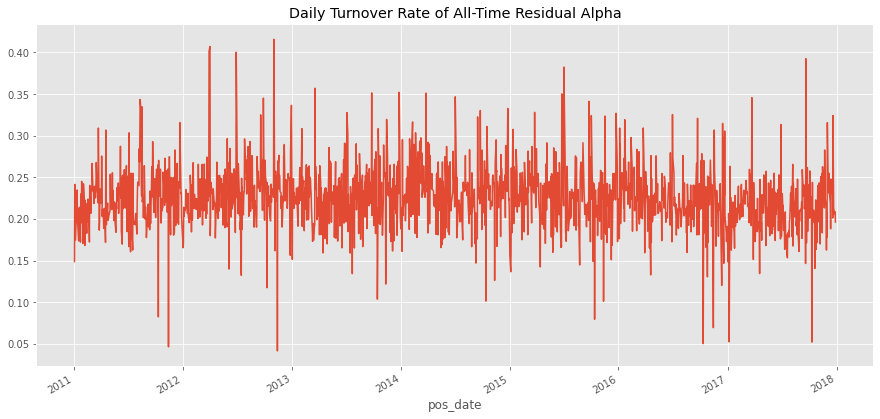

In [44]:
to_risk_residual = calc_daily_to(df_risk_residual, 'Resid', 'pos_date', 'security_id')
to_risk_residual.plot(title='Daily Turnover Rate of All-Time Residual Alpha')

In [45]:
print("Calc Yearly MaxDD and the Length\n\n")

dret_df_risk_residual['year'] = dret_df_risk_residual['pos_date'].dt.year
print(dret_df_risk_residual.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(dret_df_risk_residual.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length


      Max_Drawdown  Length
year                      
2011        -0.005    10.0
2012        -0.006    31.0
2013        -0.005    46.0
2014        -0.011    93.0
2015        -0.006    44.0
2016        -0.008    35.0
2017        -0.003    16.0 

Max Drawdown of all times:
 Max_Drawdown    -0.011
Length          93.000
dtype: float64


In [46]:
print("Compute % of positive portfolio return days for each year:")
dret_df_risk_residual.groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    57.54
2012    54.40
2013    51.59
2014    55.56
2015    50.79
2016    48.41
2017    52.80
Name: attr_fwdretf1, dtype: float64

## Save the original score

In [47]:
alpha9 = df.loc[df['pos_date'] >= '2011-01-01', 
                ['pos_date', 'security_id', 'clip_trisk', 'fwdret_f1', 'sector', 'z63_score', 'z126_score', 'z252_score', 'combined_score']]

Dropping the NaN rows from combined_score column
alpha9.head():
         pos_date security_id  clip_trisk  fwdret_f1                  sector  \
394906 2011-01-03     1004601   62.162621  -0.020927  Information Technology   
394907 2011-01-03      100701   19.749199  -0.009325               Utilities   
394908 2011-01-03     1007201   37.389405  -0.011587  Consumer Discretionary   
394909 2011-01-03     1009601   29.017306  -0.029014        Consumer Staples   
394910 2011-01-03    10116101   55.507777   0.007392             Industrials   

        z63_score  z126_score  z252_score  combined_score  
394906  -0.213027   -0.784182   -1.372490       -0.843922  
394907  -1.565770   -1.800624   -1.684806       -1.799270  
394908  -2.227241   -1.843113   -2.057259       -2.182768  
394909  -1.015814   -0.779241   -0.852388       -0.942875  
394910  -1.656694   -0.290223   -0.055800       -0.713176  


alpha9.tail():
          pos_date security_id  clip_trisk  fwdret_f1                  sector 

<AxesSubplot:title={'center':'Daily number of stocks with valid combined_score computed from dataset 9'}, xlabel='pos_date'>

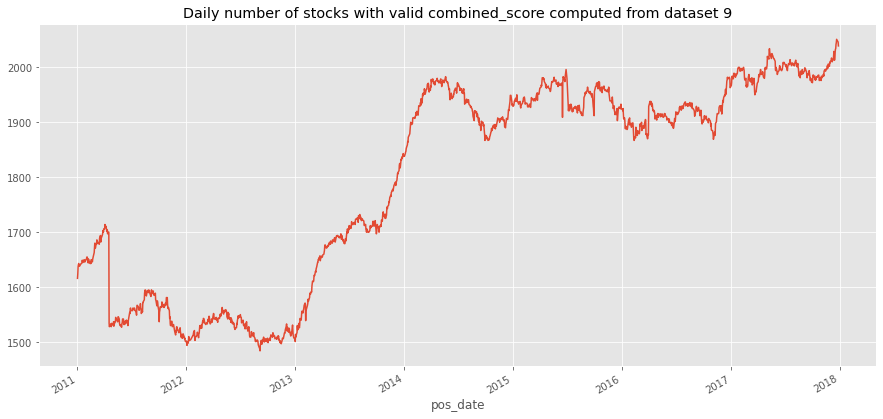

In [48]:
print("Dropping the NaN rows from combined_score column")
alpha9.dropna(subset=['combined_score'], inplace=True)

print(f"alpha9.head():\n{alpha9.head()}\n\n")
print(f"alpha9.tail():\n{alpha9.tail()}\n\n")
alpha9.groupby('pos_date').size().plot(title='Daily number of stocks with valid combined_score computed from dataset 9')

In [49]:
SAVE_TO_FILE_PATH = os.path.join(PROCESSED_DATA_DIR, 'original_alpha9.csv.gz')
print(f"Saving file to {SAVE_TO_FILE_PATH}")
alpha9.to_csv(os.path.join(PROCESSED_DATA_DIR, 'original_alpha9.csv.gz'), index=False, compression='gzip')

Saving file to /home/jma/Python3.7/Cubist_2021_11/processed_data/original_alpha9.csv.gz
